In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initalize(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True)

def make_env(seed):
    env = gym.make("Taxi-v3")
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def preprocess_state_with_walls(state, env):
    row, col, pass_loc, dest_idx = env.unwrapped.decode(state)
    row_onehot = np.eye(5)[row]
    col_onehot = np.eye(5)[col]
    passloc_onehot = np.eye(5)[pass_loc]
    dest_onehot = np.eye(4)[dest_idx]

    state_vec = np.concatenate([row_onehot, col_onehot, passloc_onehot, dest_onehot])
    return state_vec


class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.structure = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.structure(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


def train_q_with_fixed_w(model, target_net, w, episodes, alpha, gamma, epsilon, epsilon_decay,
                         min_epsilon, optimizer, memory, batch_size, env, rewards,
                         feature_value_data, print_every=10):
    for episode in range(episodes):
        model.train()
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_vec = preprocess_state_with_walls(state, env)
            state_tensor = torch.from_numpy(state_vec.astype(np.float32)).unsqueeze(0).to(device)

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = model(state_tensor)
                action = q_vals.argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            memory.push(state, action, reward, next_state, done)
            state = next_state

            if len(memory) >= batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = memory.sample(batch_size)

                s_array = np.array([preprocess_state_with_walls(s, env) for s in s_batch], dtype=np.float32)
                s_tensor = torch.from_numpy(s_array).float().to(device)
                a_tensor = torch.tensor(a_batch, dtype=torch.int64).unsqueeze(1).to(device)
                r_tensor = torch.tensor(r_batch, dtype=torch.float32).unsqueeze(1).to(device)
                ns_array = np.array([preprocess_state_with_walls(ns, env) for ns in ns_batch], dtype=np.float32)
                ns_tensor = torch.from_numpy(ns_array).float().to(device)
                d_tensor = torch.tensor(d_batch, dtype=torch.float32).unsqueeze(1).to(device)

                q_values = model(s_tensor)
                q_selected = q_values.gather(1, a_tensor)

                with torch.no_grad():
                    q_next = target_net(ns_tensor)
                    max_q_next = q_next.max(1)[0].unsqueeze(1)
                    
                shaping_bonus = ((gamma * ns_tensor - s_tensor) * w.detach()).sum(dim=1).unsqueeze(-1)

                shaped_reward = r_tensor + shaping_bonus

                target = shaped_reward + gamma * max_q_next * (1 - d_tensor)
                loss = nn.MSELoss()(q_selected, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    q_vals_all = model(s_tensor)
                    v_vals = q_vals_all.max(1)[0]
                    for f, v in zip(s_tensor, v_vals):
                        feature_value_data.append((f.cpu().numpy(), v.item()))
                    if len(feature_value_data) > 10000:
                        feature_value_data = feature_value_data[-10000:]

        rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if episode % print_every == 0 or episode == episodes - 1:
            target_net.load_state_dict(model.state_dict())
            print(f"  [Q] Episode {episode:4d} | Reward: {total_reward:4d} | Epsilon: {epsilon:.3f}")
    return epsilon


def train_w_supervised(feature_value_data, w, epochs=100, lr=0.01):
    features = np.array([f for f, _ in feature_value_data], dtype=np.float32)
    values = np.array([v for _, v in feature_value_data], dtype=np.float32).reshape(-1, 1)

    X = torch.from_numpy(features).to(device)
    y = torch.from_numpy(values).to(device)

    w = nn.Parameter(w.clone().detach().unsqueeze(1), requires_grad=True)
    optimizer = optim.Adam([w], lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        pred = X @ w
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return w.detach().squeeze()


def train_bilevel_vrail(cycles=20, q_train_episodes=100, w_epochs=50,
                        alpha=0., gamma=0.99, epsilon=1.0,
                        epsilon_decay=0.995, min_epsilon=0.01,
                        dqn_lr=0.001, w_lr=0.01,
                        batch_size=64, memory_size=50000, seed=42):
    initalize(seed)
    env = make_env(seed)
    state_size = 19
    action_size = env.action_space.n

    model = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(model.state_dict())
    target_net.eval()

    optimizer = optim.Adam(model.parameters(), lr=dqn_lr)
    memory = ReplayBuffer(memory_size)
    rewards = []
    w = torch.zeros(state_size).to(device)

    for cycle in range(cycles):
        feature_value_data = []

        print(f"\n🔁 Bi-level cycle {cycle + 1}/{cycles}")

        mod_epsilon = epsilon * (epsilon_decay ** (q_train_episodes * cycle))

        train_q_with_fixed_w(
            model, target_net, w, q_train_episodes, alpha, gamma,
            mod_epsilon, epsilon_decay, min_epsilon,
            optimizer, memory, batch_size, env,
            rewards, feature_value_data,
            print_every=10
        )

        w = train_w_supervised(feature_value_data, w, epochs=w_epochs, lr=w_lr)
        target_net.load_state_dict(model.state_dict())

    env.close()

    settings = {
         'cycles': cycles,
         'DQN_epochs': q_train_episodes,
         'w_epochs': w_epochs,
         'alpha': alpha,
         'gamma': gamma,
         'epsilon': epsilon,
         'epsilon_decay': epsilon_decay,
         'min_epsilon': min_epsilon,
         'DQN_lr': dqn_lr,
         'w_lr': w_lr,
         'batch_size': batch_size,
         'memory_size': memory_size,
         'seed': seed
    }

    return rewards, model, w, settings


def moving_average(data, window=50):
    return np.convolve(data, np.ones(window) / window, mode='valid')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

def save_experiment_results(rewards_DQN, w_DQN, model_DQN, settings, label):
    alpha = settings.get("alpha", "NA")
    seed = settings.get("seed", "NA")

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    folder_name = f"{timestamp}_alpha{alpha}_seed{seed}"
    save_dir = os.path.join("results_dqn", folder_name)
    os.makedirs(save_dir, exist_ok=True)

    np.savetxt(os.path.join(save_dir, "rewards.csv"), rewards_DQN, delimiter=",", header="reward", comments='', fmt="%.1f")

    weight_file = os.path.join(save_dir, "weights.csv")
    if w_DQN.ndim == 1:
        np.savetxt(weight_file, w_DQN.reshape(1, -1), delimiter=",", header=",".join([f"w{i}" for i in range(len(w_DQN))]), comments='', fmt="%.4f")
    else:
        np.savetxt(weight_file, w_DQN, delimiter=",", header=",".join([f"w{i}" for i in range(w_DQN.shape[1])]), comments='', fmt="%.4f",)

    with open(os.path.join(save_dir, "model.pkl"), "wb") as f:
        pickle.dump(model_DQN, f)

    with open(os.path.join(save_dir, "settings.txt"), "w") as f:
        for key, value in settings.items():
            f.write(f"{key}: {value}\n")

    plt.figure()
    plt.plot(rewards_DQN, label=label)
    plt.plot(moving_average(rewards_DQN), label='Moving Avg (50)')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"VRAIL (alpha={alpha}, seed={seed})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "reward_plot.png"))
    plt.close()

    print(f"Saved results to: {save_dir}")


🔁 Bi-level cycle 1/20
  [Q] Episode    0 | Reward: -740 | Epsilon: 0.995
  [Q] Episode   10 | Reward: -785 | Epsilon: 0.946
  [Q] Episode   20 | Reward: -749 | Epsilon: 0.900
  [Q] Episode   30 | Reward: -731 | Epsilon: 0.856
  [Q] Episode   40 | Reward: -305 | Epsilon: 0.814
  [Q] Episode   50 | Reward: -686 | Epsilon: 0.774
  [Q] Episode   60 | Reward: -596 | Epsilon: 0.737
  [Q] Episode   70 | Reward: -416 | Epsilon: 0.701
  [Q] Episode   80 | Reward: -425 | Epsilon: 0.666
  [Q] Episode   90 | Reward: -497 | Epsilon: 0.634
  [Q] Episode   99 | Reward: -470 | Epsilon: 0.606

🔁 Bi-level cycle 2/20
  [Q] Episode    0 | Reward: -357 | Epsilon: 0.603
  [Q] Episode   10 | Reward: -551 | Epsilon: 0.573
  [Q] Episode   20 | Reward: -461 | Epsilon: 0.545
  [Q] Episode   30 | Reward: -542 | Epsilon: 0.519
  [Q] Episode   40 | Reward: -425 | Epsilon: 0.493
  [Q] Episode   50 | Reward: -452 | Epsilon: 0.469
  [Q] Episode   60 | Reward: -470 | Epsilon: 0.446
  [Q] Episode   70 | Reward: -362 | 

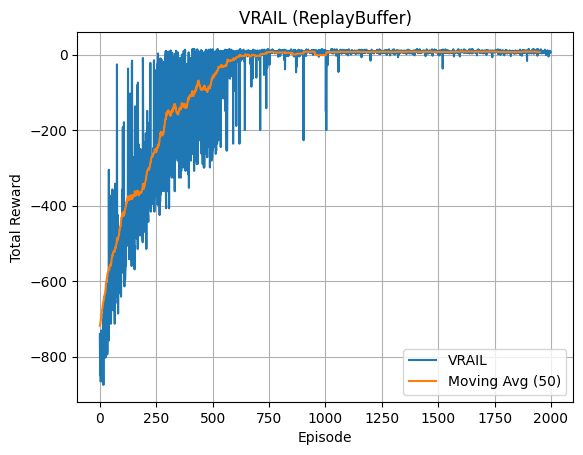

In [40]:
# 실행
rewards, model, w, settings = train_bilevel_vrail(seed=4)

# 시각화
plt.plot(rewards, label='VRAIL')
plt.plot(moving_average(rewards), label='Moving Avg (50)')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("VRAIL (ReplayBuffer)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
save_experiment_results(rewards, w.cpu(), model, settings, label='DQN')

Saved results to: results_dqn/2025-05-31_22-41-50_alpha0.0_seed4


In [42]:
R = moving_average(rewards)
thresholds = [-10, -5, 0, 5]

idx = lambda arr, threshold: np.argmax(np.array(arr) >= threshold)
print([int(idx(R, i))+50 for i in thresholds])
print("Last", R[-1])
print("Max", max(R))

print(w[:5])
print(w[5:10])
print(w[10:15])
print(w[15:19])
print(w[19:])

[642, 670, 694, 789]
Last 6.92
Max 8.4
tensor([2.8686, 2.7234, 2.5454, 2.5548, 2.4906], device='cuda:0')
tensor([2.8385, 2.0089, 1.6775, 2.5307, 2.0493], device='cuda:0')
tensor([-0.6068, -0.8888, -0.8602, -0.0122,  3.9180], device='cuda:0')
tensor([1.8755, 2.1925, 1.5971, 2.4755], device='cuda:0')
tensor([], device='cuda:0')
